<a href="https://colab.research.google.com/github/Team-AlmaBetter/Retail-Sales-Prediction/blob/main/Rossmann_Sales_Prediction_Capstone_Project_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Sales Prediction : Predicting sales of a major store chain Rossmann</u></b>

## <b> Problem Description </b>

### Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

### You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

## <b> Data Description </b>

### <b>Rossmann Stores Data.csv </b> - historical data including Sales
### <b>store.csv </b> - supplemental information about the stores


### <b><u>Data fields</u></b>
### Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* #### Id - an Id that represents a (Store, Date) duple within the test set
* #### Store - a unique Id for each store
* #### Sales - the turnover for any given day (this is what you are predicting)
* #### Customers - the number of customers on a given day
* #### Open - an indicator for whether the store was open: 0 = closed, 1 = open
* #### StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* #### SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* #### StoreType - differentiates between 4 different store models: a, b, c, d
* #### Assortment - describes an assortment level: a = basic, b = extra, c = extended
* #### CompetitionDistance - distance in meters to the nearest competitor store
* #### CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* #### Promo - indicates whether a store is running a promo on that day
* #### Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* #### Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* #### PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

#<b>1. Import necessary libraries

In [6]:
import pandas as pd, datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
get_ipython().run_line_magic('matplotlib', 'inline')
from time import time
from math import sqrt
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, r2_score
import plotly.graph_objs as go
from matplotlib.pyplot import *

#<b>2. Data Preparation

##<b>2.1 Import Datasets

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
R_data = pd.read_csv('/content/drive/MyDrive/Retail Sales Prediction-Capstone 2/Data & Resources/Rossmann Stores Data.csv')
R_data.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.



,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [9]:
R_data.tail()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1
1017208,1115,2,2013-01-01,0,0,0,0,a,1


In [10]:
R_data.shape

(1017209, 9)

In [11]:
store = pd.read_csv('/content/drive/MyDrive/Retail Sales Prediction-Capstone 2/Data & Resources/store.csv')
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [12]:
store.tail()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN
1114,1115,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


In [13]:
store.shape

(1115, 10)

##<b>2.2 Dealing With Missing Values 

###<b>2.2.1 Count missing values in each dataset

In [14]:
print("R_data:\n\n", R_data.isnull().sum(),  
     "\n\nstore:\n\n", store.isnull().sum())

R_data:

 Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64 

store:

 Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64


### 2.2.2 Replace missing values in features with low percentages of missing values

In [15]:
# check for any null values
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

### Let's start the cleansing process by order

CompetitionDistance:

Since Competition distance have 3 null values.


Before deciding how to treat this,we know there are infinite ways of filling missing values.

The most common and simplistic approach is to fill it with either the mean or the median of this variable.


It is realistically better to input the median value to the three Nan stores then the mean since the mean is biased by those outliers.

In [16]:
# filling competition distance with mean
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)


In [17]:
# lets check again for null value
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            0
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

##<b>2.3 Date Extraction

Lets extract the dates from date features
Since we have only dates, we will extract years, months, day and week of the year.

In [18]:
R_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


  Firstly convert the datatype of 'Date' column to datetime format

In [19]:
# converting to datetime datatype

R_data['Date']=pd.to_datetime(R_data['Date'])

In [20]:
R_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


In [21]:
# extract year, month, day and week of year from "Date"
R_data['Year'] =pd.DatetimeIndex(R_data['Date']).year
R_data['Month'] =pd.DatetimeIndex(R_data['Date']).month
R_data['Day'] =pd.DatetimeIndex(R_data['Date']).day
R_data['WeekOfYear'] = pd.DatetimeIndex(R_data['Date']).weekofyear
# R_data = R_data.reset_index()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)



In [22]:
R_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 13 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  int64         
 9   Year           1017209 non-null  int64         
 10  Month          1017209 non-null  int64         
 11  Day            1017209 non-null  int64         
 12  WeekOfYear     1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(11), object(1)
memory usage: 100.9+ MB


##<b> 2.4 Joining Tables

Now join the table R_data and store dataframe 

In [23]:
data = pd.merge(R_data, store, how='left', on='Store')
data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,7,31,31,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,7,31,31,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,2015,7,31,31,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,2015,7,31,31,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,2015,7,31,31,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 22 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  object        
 8   SchoolHoliday              1017209 non-null  int64         
 9   Year                       1017209 non-null  int64         
 10  Month                      1017209 non-null  int64         
 11  Day                        1017209 no

In [25]:
data.isnull().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
Year                              0
Month                             0
Day                               0
WeekOfYear                        0
StoreType                         0
Assortment                        0
CompetitionDistance               0
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64

##<b>Checking the nominal values

In [26]:
# Nominal Values
set(data.StateHoliday),set(data.Assortment),set(data.StoreType)

({0, '0', 'a', 'b', 'c'}, {'a', 'b', 'c'}, {'a', 'b', 'c', 'd'})

Since StateHoliday have zero for none.
let's convert that into string '0'

In [27]:
# converting 0 to string '0'
data.loc[data.StateHoliday == 0,'StateHoliday'] = data.loc[data.StateHoliday == 0,'StateHoliday'].astype(str)

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 22 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  object        
 8   SchoolHoliday              1017209 non-null  int64         
 9   Year                       1017209 non-null  int64         
 10  Month                      1017209 non-null  int64         
 11  Day                        1017209 no

###Checking data(merged) columns,unique values

In [29]:
data.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Day', 'WeekOfYear',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [30]:
data.nunique()

Store                         1115
DayOfWeek                        7
Date                           942
Sales                        21734
Customers                     4086
Open                             2
Promo                            2
StateHoliday                     4
SchoolHoliday                    2
Year                             3
Month                           12
Day                             31
WeekOfYear                      52
StoreType                        4
Assortment                       3
CompetitionDistance            655
CompetitionOpenSinceMonth       12
CompetitionOpenSinceYear        23
Promo2                           2
Promo2SinceWeek                 24
Promo2SinceYear                  7
PromoInterval                    3
dtype: int64

In [31]:
data.Date.unique()#to check seperately

array(['2015-07-31T00:00:00.000000000', '2015-07-30T00:00:00.000000000',
       '2015-07-29T00:00:00.000000000', '2015-07-28T00:00:00.000000000',
       '2015-07-27T00:00:00.000000000', '2015-07-26T00:00:00.000000000',
       '2015-07-25T00:00:00.000000000', '2015-07-24T00:00:00.000000000',
       '2015-07-23T00:00:00.000000000', '2015-07-22T00:00:00.000000000',
       '2015-07-21T00:00:00.000000000', '2015-07-20T00:00:00.000000000',
       '2015-07-19T00:00:00.000000000', '2015-07-18T00:00:00.000000000',
       '2015-07-17T00:00:00.000000000', '2015-07-16T00:00:00.000000000',
       '2015-07-15T00:00:00.000000000', '2015-07-14T00:00:00.000000000',
       '2015-07-13T00:00:00.000000000', '2015-07-12T00:00:00.000000000',
       '2015-07-11T00:00:00.000000000', '2015-07-10T00:00:00.000000000',
       '2015-07-09T00:00:00.000000000', '2015-07-08T00:00:00.000000000',
       '2015-07-07T00:00:00.000000000', '2015-07-06T00:00:00.000000000',
       '2015-07-05T00:00:00.000000000', '2015-07-04

<B>The dataset is from 1 January 2013 to 31 July 2015 , i.e. approx. 2.5 yrs.

In [32]:

li = ["DayOfWeek" , "StateHoliday" , "SchoolHoliday"]

for i in li:
  print(i)
  print(data[i].unique())
  print("-----------------------")

DayOfWeek
[5 4 3 2 1 7 6]
-----------------------
StateHoliday
['0' 'a' 'b' 'c']
-----------------------
SchoolHoliday
[1 0]
-----------------------


<b>a = public holiday, b = Easter holiday, c = Christmas, 0 = No holidays

Indicates if the (Store, Date) was affected by the closure of public schools

In [33]:
data.Store.nunique()

1115

#<b>3. Exploratory Data Analysis

##<B> 3.1 Opened store

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



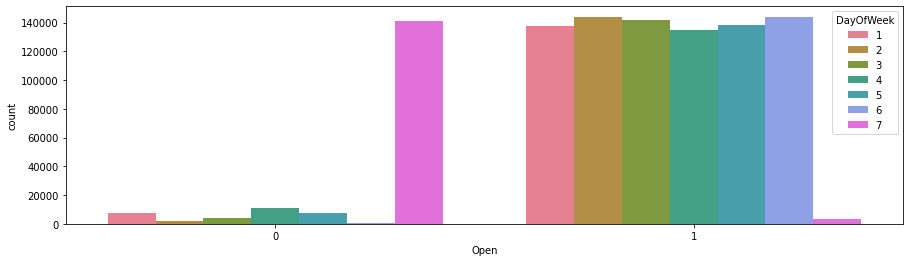

In [34]:
# Open
fig, (axis1) = plt.subplots(1,1,figsize=(15,4))
sns.countplot(x='Open',hue='DayOfWeek', data=data,palette="husl", ax=axis1)

# fill NaN values in data with Open=1 if DayOfWeek != 7
data["Open"][data["Open"] != data["Open"]] = (data["DayOfWeek"] != 7).astype(int)

# Drop Open column

data.drop("Open", axis=1, inplace=True)

##<B> 3.2. Average Sales & Sales percent change

In [35]:
# Date

# Create Year and Month columns

data['Year']  = data['Date'].apply(lambda x: int(str(x)[:4]))
data['Month'] = data['Date'].apply(lambda x: int(str(x)[5:7]))

# Assign Date column to Date(Year-Month) instead of (Year-Month-Day)
# this column will be useful in analysis and visualization

data['Date'] = data['Date'].apply(lambda x: (str(x)[:7]))

##<B> 3.3. Average sales over time(year-month)

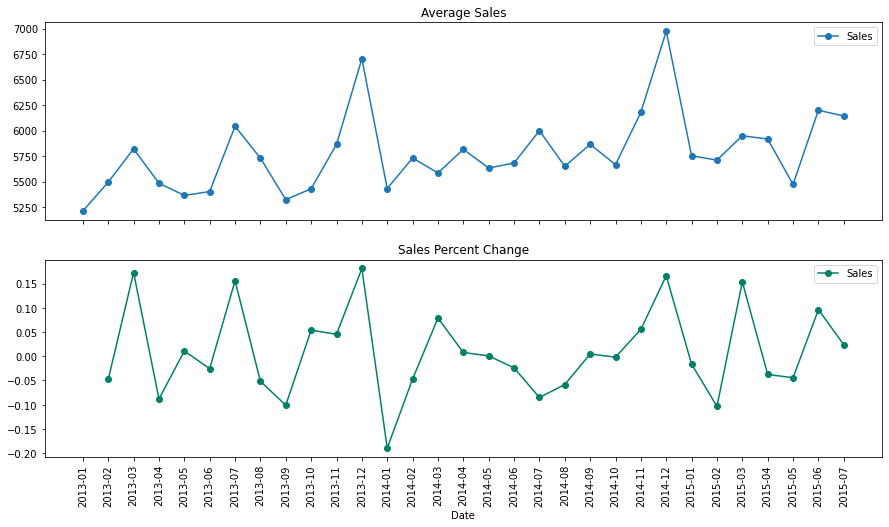

In [36]:
# group by date and get average sales, and precent change
average_sales    = data.groupby('Date')["Sales"].mean()
pct_change_sales = data.groupby('Date')["Sales"].sum().pct_change()

fig, (axis1,axis2) = plt.subplots(2,1,sharex=True,figsize=(15,8))

# plot average sales over time(year-month)
ax1 = average_sales.plot(legend=True,ax=axis1,marker='o',title="Average Sales")
ax1.set_xticks(range(len(average_sales)))
ax1.set_xticklabels(average_sales.index.tolist(), rotation=90)

# plot precent change for sales over time(year-month)
ax2 = pct_change_sales.plot(legend=True,ax=axis2,marker='o',rot=90,colormap="summer",title="Sales Percent Change")
# ax2.set_xticks(range(len(pct_change_sales)))
# ax2.set_xticklabels(pct_change_sales.index.tolist(), rotation=90)

##<B> 3.4. Average sales & customers for every year

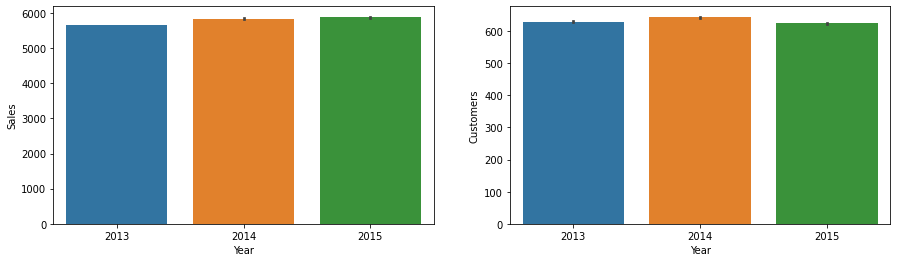

In [37]:
# .... contiune with Date

# Plot average sales & customers for every year
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='Year', y='Sales', data=data, ax=axis1)
sns.barplot(x='Year', y='Customers', data=data, ax=axis2)

# Drop Date column

data.drop(['Date'], axis=1,inplace=True)

##<B>  3.5. DayOfWeek

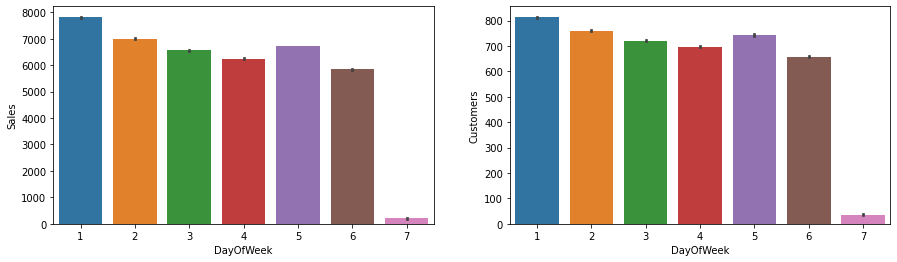

In [38]:
# DayOfWeek
# In both cases where the store is closed and opened

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='DayOfWeek', y='Sales', data=data, order=[1,2,3,4,5,6,7], ax=axis1)
sns.barplot(x='DayOfWeek', y='Customers', data=data, order=[1,2,3,4,5,6,7], ax=axis2)


##<B>3.6. StateHoliday

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



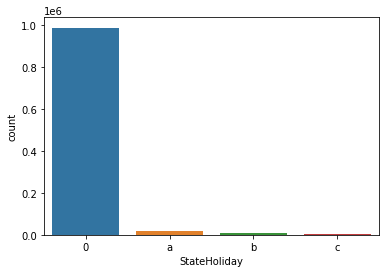

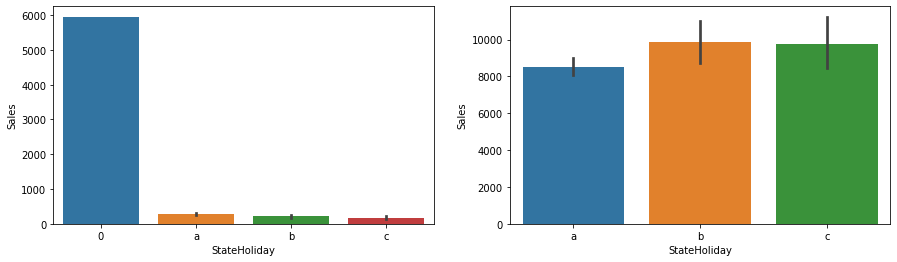

In [39]:
# StateHoliday

# StateHoliday column has values 0 & "0", So, we need to merge values with 0 to "0"
data["StateHoliday"].loc[data["StateHoliday"] == 0] = "0"

# Plot
sns.countplot(x='StateHoliday', data=data)

# Before
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='StateHoliday', y='Sales', data=data, ax=axis1)

mask = (data["StateHoliday"] != "0") & (data["Sales"] > 0)
sns.barplot(x='StateHoliday', y='Sales', data=data[mask], ax=axis2)

continue with StateHoliday

We have StateHoliday as Obejcts we need to convert them to numerical categories:



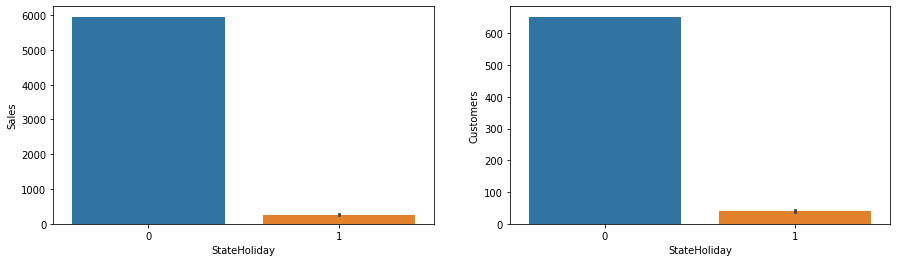

In [40]:
# .... continue with StateHoliday

# After
data["StateHoliday"]     = data["StateHoliday"].map({0: 0, "0": 0, "a": 1, "b": 1, "c": 1})

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='StateHoliday', y='Sales', data=data, ax=axis1)
sns.barplot(x='StateHoliday', y='Customers', data=data, ax=axis2)

From the graph, we can see that, Sales and customer are dramatically high on stateholidays


##<b>3.7. Sales affected by SchoolHoliday or not?

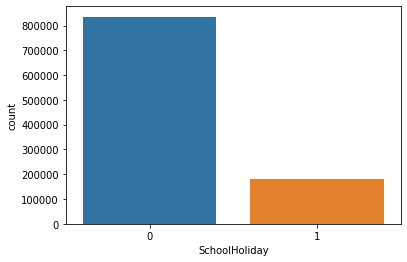

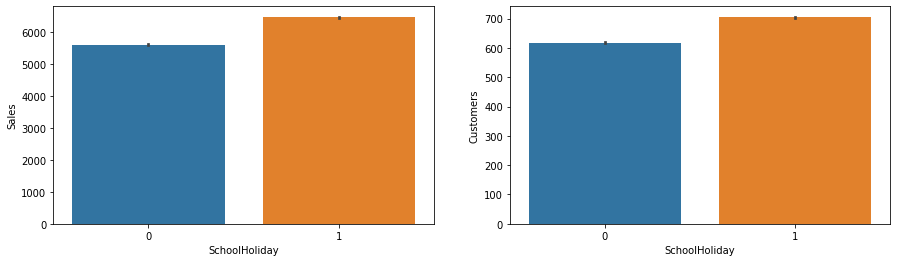

In [41]:
# SchoolHoliday

# Plot
sns.countplot(x='SchoolHoliday', data=data)

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='SchoolHoliday', y='Sales', data=data, ax=axis1)
sns.barplot(x='SchoolHoliday', y='Customers', data=data, ax=axis2)

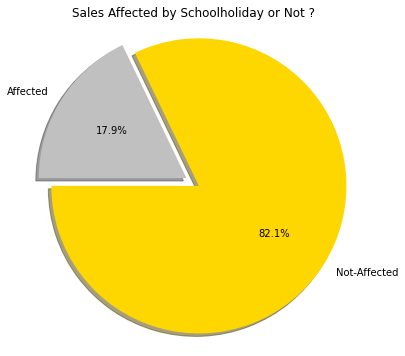

In [42]:
labels = 'Not-Affected' , 'Affected'
sizes = data.SchoolHoliday.value_counts()
colors = ['gold', 'silver']
explode = (0.1, 0.0)
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=180)
plt.axis('equal')
plt.title("Sales Affected by Schoolholiday or Not ?")
plt.plot()
fig=plt.gcf()
fig.set_size_inches(6,6)
plt.show()

##<B>3.8 Sales by StoreTypes

In [43]:
temp = []
for i in data.groupby('Store')[["Sales", "Customers"]].mean()["Sales"]:
  temp.append(i)
store["AvgSales"] = temp

In [44]:
temp = []
for i in data.groupby('Store')[["Sales", "Customers"]].mean()["Customers"]:
  temp.append(i)
store["AvgCustomers"] = temp

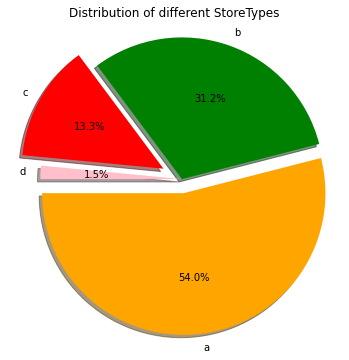

In [45]:
labels = 'a' , 'b' , 'c' , 'd'
sizes = store.StoreType.value_counts()
colors = ['orange', 'green' , 'red' , 'pink']
explode = (0.1, 0.0 , 0.15 , 0.0)
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=180)
plt.axis('equal')
plt.title("Distribution of different StoreTypes")
plt.plot()
fig=plt.gcf()
fig.set_size_inches(6,6)
plt.show()

##<B> 3.9. StoreType, & StoreType Vs average sales and customers

The best way to asses the performance of a store type is to see what is the sales per customer so that we normalize everything and we get the store that makes its customers spend the most on average.

Let's compare first the total sales of each store type, its average sales and then see how it changes when we add the customers to the equation:

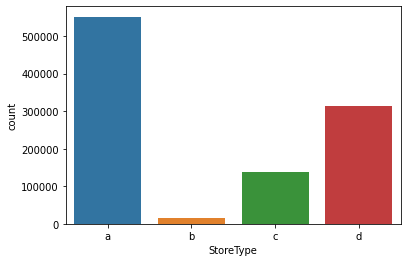

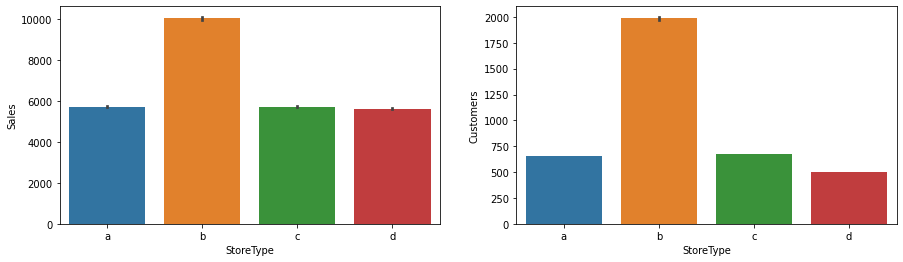

In [46]:
# StoreType 

# Plot StoreType, & StoreType Vs average sales and customers

sns.countplot(x='StoreType', data=data, order=['a','b','c', 'd'])

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='StoreType', y='Sales', data=data, order=['a','b','c', 'd'],ax=axis1)
sns.barplot(x='StoreType', y='Customers', data=data, order=['a','b','c', 'd'], ax=axis2)

**Findings:**

From this training set we can see that Storetype A 
has the highest number of branches,sales and customers from the 4 different storetypes. But this doesn't mean it's the best performing Storetype.


When looking at the average sales and number of customers, we see that actually it is Storetype B who was the highest average Sales and highest average Number of Customers. One assumption could be that if B has only 17 stores but such a high amount of average sales and customers that it is likely hyper Rossman branches whereas A would be smaller in size but much more present.

#####<b>Stores which are opened on Sundays

In [47]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            0
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
AvgSales                       0
AvgCustomers                   0
dtype: int64

In [48]:
R_data.SchoolHoliday.value_counts()

0    835488
1    181721
Name: SchoolHoliday, dtype: int64

##<B> 3.10. Assortment, & Assortment Vs average sales and customers

As we cited in the description, assortments have three types and each store has a defined type and assortment type:





*   a-means basic things
*   b-means extra things
*   c-means extended things so the highest variety    of products.









What could be interesting is to see the relationship between a store type and its respective assortment type.

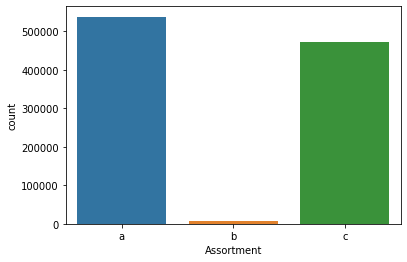

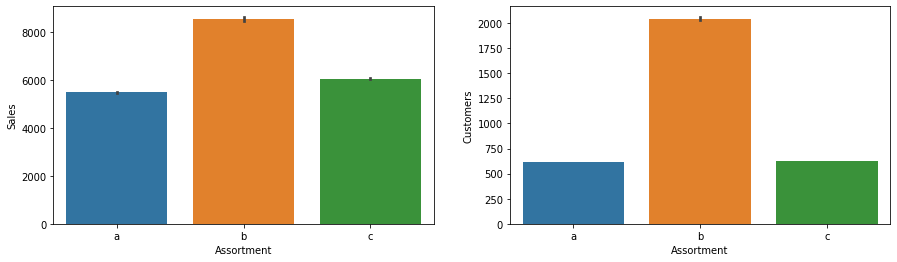

In [49]:
# Assortment 

# Plot Assortment, & Assortment Vs average sales and customers

sns.countplot(x='Assortment', data=data, order=['a','b','c'])

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='Assortment', y='Sales', data=data, order=['a','b','c'], ax=axis1)
sns.barplot(x='Assortment', y='Customers', data=data, order=['a','b','c'], ax=axis2)

Findings:

We can clearly see here that most of the stores have either a assortment type or c assortment type.


Interestingly enough assortment type B have maximum sales and customers.


##<B> 3.11. CompetitionDistance

What we find also interesting to plot is the effect of the closest competition distance on Sales, to see whether the one with very far competition actually make more sales then the one with close competition.

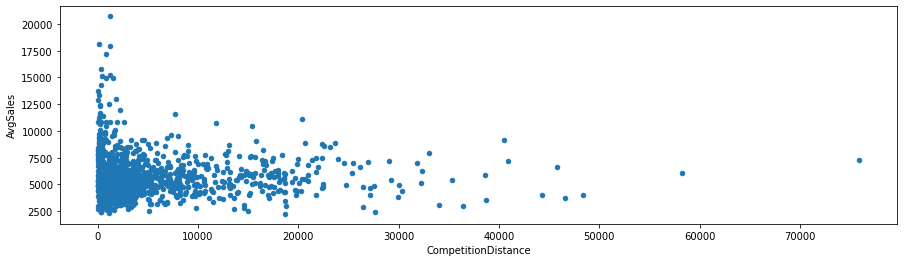

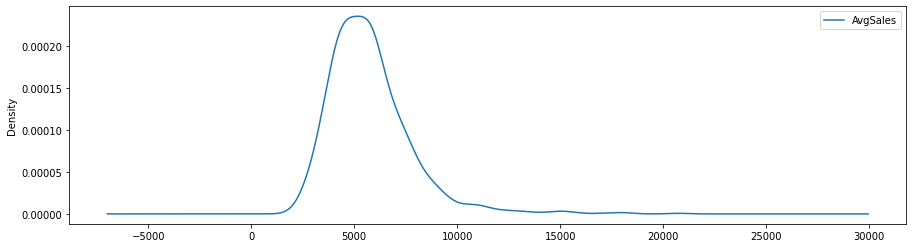

In [50]:
# CompetitionDistance

# Plot CompetitionDistance Vs Sales

store.plot(kind='scatter',x='CompetitionDistance',y='AvgSales',figsize=(15,4))
store.plot(kind='kde',x='CompetitionDistance',y='AvgSales',figsize=(15,4))

Findings:

As we can see here, like i thought, the stores that are the furthest have the highest average sales and number of customers.

This doesn't mean automatically that the furthest the better, but it does shed light on the fact that when there are no competition nearby, stores tend to sell more and have more customers because there are almost a monopoly in this region. We could think of it as McDonalds on highways where there are no other restaurants around, people who are hungry are forced to go there to eat.

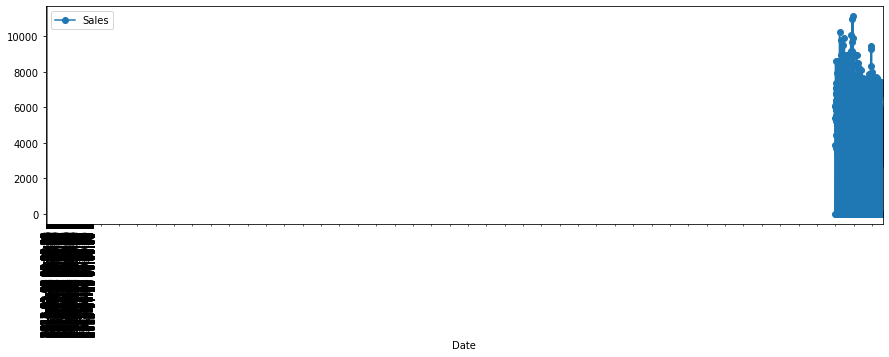

In [51]:
# What happened to the average sales of a store over time when competition started?
# Example: the average sales for store_id = 6 has dramatically decreased since the competition started

store_id = 6
store_data = R_data[R_data["Store"] == store_id]

average_store_sales = store_data.groupby('Date')["Sales"].mean()

# Get year, and month when Competition started
y = store["CompetitionOpenSinceYear"].loc[store["Store"]  == store_id].values[0]
m = store["CompetitionOpenSinceMonth"].loc[store["Store"] == store_id].values[0]

# Plot 
ax = average_store_sales.plot(legend=True,figsize=(15,4),marker='o')
ax.set_xticks(range(len(average_store_sales)))
ax.set_xticklabels(average_store_sales.index.tolist(), rotation=90)

# Since all data of store sales given in rossmann_df starts with year=2013 till 2015,
# So, we need to check if year>=2013 and y & m aren't NaN values.
if y >= 2013 and y == y and m == m:
    plt.axvline(x=((y-2013) * 12) + (m - 1), linewidth=3, color='grey')

##<b> 3.12. Sales by Season

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 20 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Sales                      1017209 non-null  int64  
 3   Customers                  1017209 non-null  int64  
 4   Promo                      1017209 non-null  int64  
 5   StateHoliday               1017209 non-null  int64  
 6   SchoolHoliday              1017209 non-null  int64  
 7   Year                       1017209 non-null  int64  
 8   Month                      1017209 non-null  int64  
 9   Day                        1017209 non-null  int64  
 10  WeekOfYear                 1017209 non-null  int64  
 11  StoreType                  1017209 non-null  object 
 12  Assortment                 1017209 non-null  object 
 13  CompetitionD

In [53]:
# Create new column Season

data['Season'] = np.where(data['Month'].isin([3,4,5]), "Spring",
                 np.where(data['Month'].isin([6,7,8]), "Summer",
                 np.where(data['Month'].isin([9,10,11]), "Fall",
                 np.where(data['Month'].isin([12,1,2]), "Winter", "None"))))

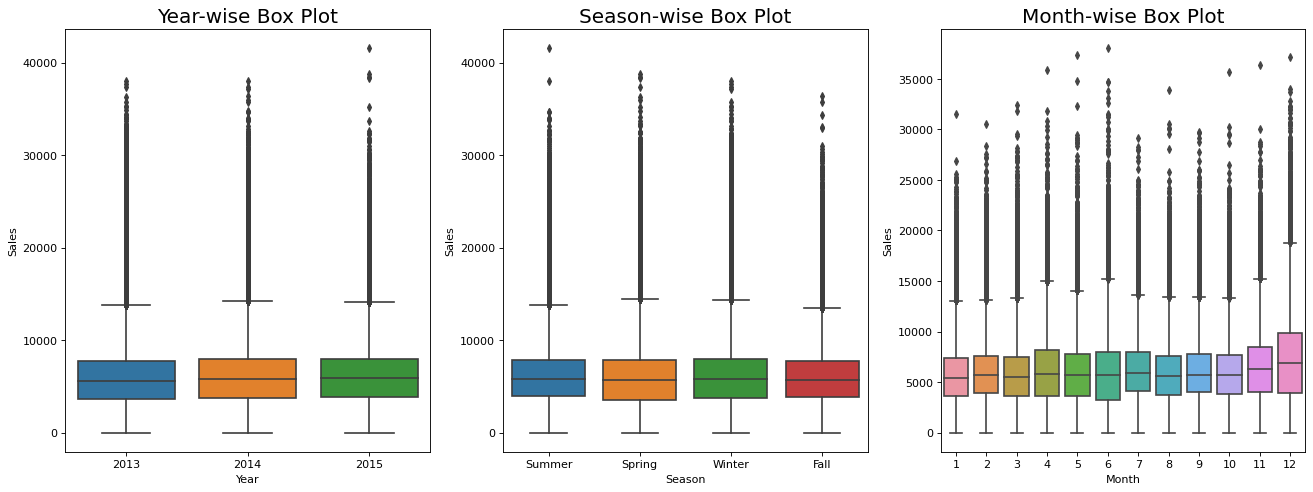

In [54]:
# Prepare data

years = data['Year'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 3, figsize=(20,7), dpi= 80)
sns.boxplot(x='Year', y='Sales', data=data, ax=axes[0])
sns.boxplot(x='Month', y='Sales', data=data.loc[~data.Year.isin([2013, 2015]), :])
sns.boxplot(x='Season', y='Sales', data=data, ax=axes[1])

# Set Title
axes[0].set_title('Year-wise Box Plot', fontsize=18)
axes[1].set_title('Season-wise Box Plot', fontsize=18)
axes[2].set_title('Month-wise Box Plot', fontsize=18)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.



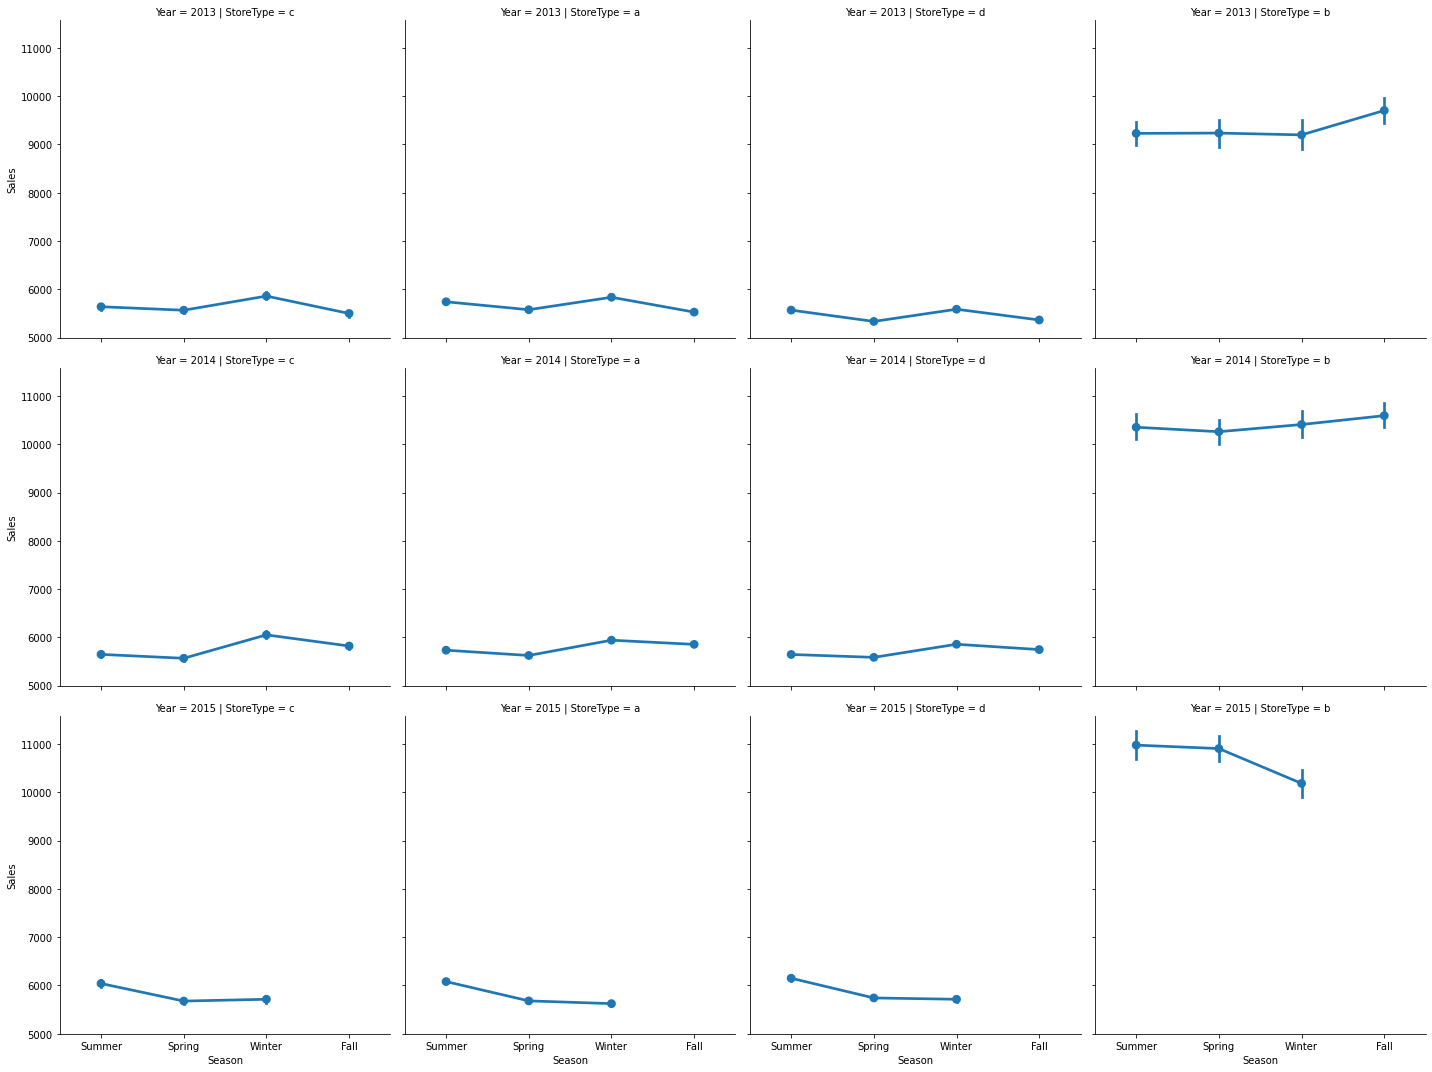

In [55]:
# Sales trend over the seasons and year
sns.factorplot(data = data, x ="Season", y = "Sales", 
               col = 'StoreType',
               row = "Year")

##<B> 3.13.  Effect of Promotion on sales

Promotion:

Let's see how Promotion affect the overall sales of Rossman by looking at when there is and when there isn't promotion over those 3 years. This allow us first to see the impact of promotion and as well to see the evolution of sales over specific years (so trends in a given year) and the gradual increase in sales from 2013 to 2015:

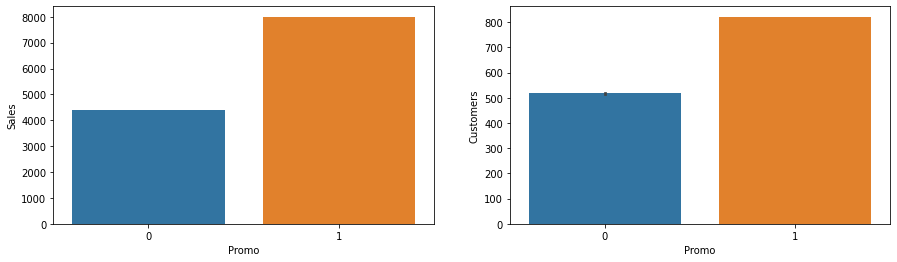

In [56]:
# Promo

# Plot average sales & customers with/without promo
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='Promo', y='Sales', data=data, ax=axis1)
sns.barplot(x='Promo', y='Customers', data=data, ax=axis2)

We see the dramatic change when we compare having promotion Promo=1 to not having promotion Promo=0 and can conclude that a store that have promotion on a given day changes its amount of sales considerably.

### Promo2 & Promo2 Vs average sales and customers

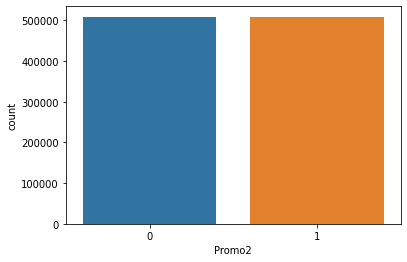

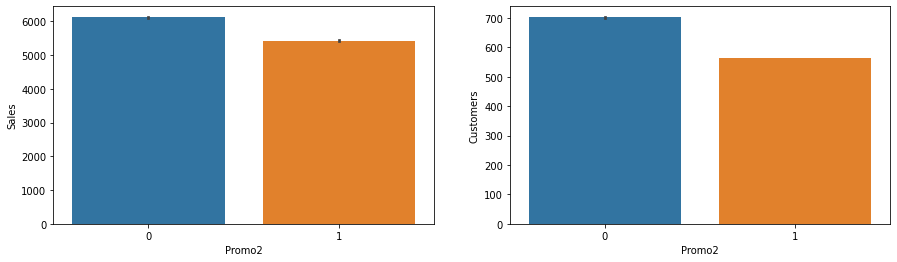

In [57]:
# Promo2

# Plot Promo2, & Promo2 Vs average sales and customers

sns.countplot(x='Promo2', data=data)

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='Promo2', y='Sales', data=data, ax=axis1)
sns.barplot(x='Promo2', y='Customers', data=data, ax=axis2)

Customer over promotion we understand that initially those stores suffer from low sales and those continuous promotion shows a tremending increase in the buying power of customers.

Text(0.5, 1.0, 'Effect of sales after second promotion')

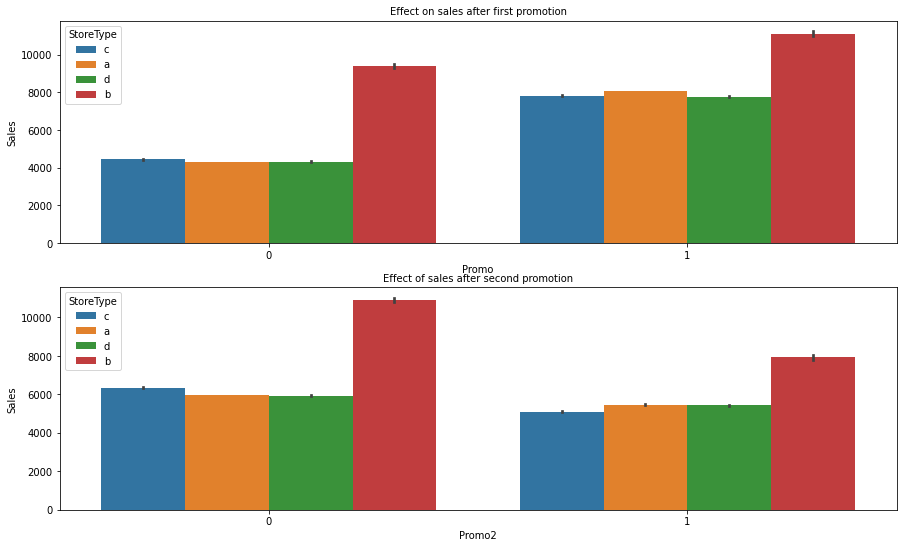

In [58]:
fig, axes = plt.subplots(2,1)
fig.set_size_inches(15,9)
sns.barplot(x= "Promo", y= "Sales", data=data ,hue="StoreType", ax=axes[0])
axes[0].set_title('Effect on sales after first promotion', fontsize=10)

sns.barplot(x= "Promo2", y= "Sales", data=data ,hue="StoreType", ax=axes[1])
axes[1].set_title('Effect of sales after second promotion', fontsize=10)

**Findings:**

First promotion have positive effect on sales, but second promotion has negative impact on sales.

##<B>3.14. Sales Distribution

In [59]:
R_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 13 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  int64         
 9   Year           1017209 non-null  int64         
 10  Month          1017209 non-null  int64         
 11  Day            1017209 non-null  int64         
 12  WeekOfYear     1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(11), object(1)
memory usage: 100.9+ MB


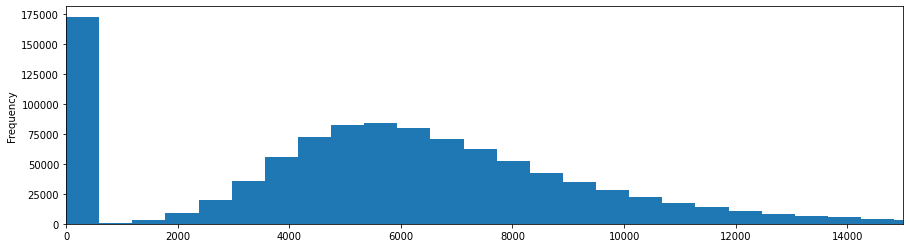

In [60]:
# Sales
fig, (axis1) = plt.subplots(1,1,figsize=(15,4))
# Plot sales values 
# Notice that values with 0 is mostly because the store was closed
R_data["Sales"].plot(kind='hist',bins=70,xlim=(0,15000),ax=axis1)

##<B> 3.15. Customer Distribution

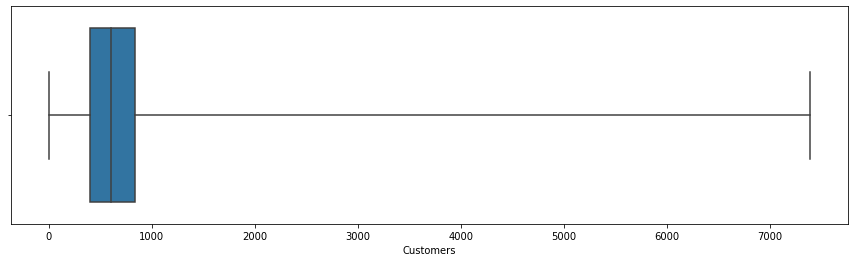

In [61]:
# Plot max, min values, & 2nd, 3rd quartile
fig, (axis1) = plt.subplots(1,1,figsize=(15,4))
sns.boxplot(x= R_data["Customers"], whis=np.inf, ax=axis1)

##<B> Risk Analysis

In [62]:
R_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 13 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  int64         
 9   Year           1017209 non-null  int64         
 10  Month          1017209 non-null  int64         
 11  Day            1017209 non-null  int64         
 12  WeekOfYear     1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(11), object(1)
memory usage: 100.9+ MB


Text(50, 50, 'Store 6')

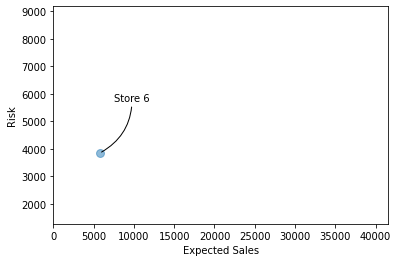

In [63]:
# Risk Analysis
# Analyze the risk of a store; Risk(std) Vs Expected(mean)

# .... countiue using data
store_average = data["Sales"].mean()
store_std     = data["Sales"].std()

# Plot
plt.scatter(store_average, store_std,alpha = 0.5,s =np.pi*20)

# Get min & max mean and std of data sales
std_sales = data.groupby('Store')["Sales"].std()

min_average = data["Sales"].min()
max_average = data["Sales"].max()
min_std     = std_sales.min()
max_std     = std_sales.max()

# Set the x and y limits of the plot
plt.ylim([min_std, max_std])
plt.xlim([min_average, max_average])

# Set the plot axis titles
plt.xlabel('Expected Sales')
plt.ylabel('Risk')

# Set label
label, x, y = "Store {}".format(store_id), store_average, store_std
plt.annotate(
        label, 
        xy = (x, y), xytext = (50, 50),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        arrowprops = dict(arrowstyle = '-', connectionstyle = 'arc3,rad=-0.3'))

#<B>4. Feature Engineering

Since we need numerical variables for both our correlation Analysis and to feed the  models, we need to transform what is not numerical to a numerical representation while keeping the logic behind it present.

## 4.1 Remove features with high percentages of missing values

We can see that some features have a high percentage of missing values and they won't be accurate as indicators, so we will remove features with more than 30% missing values.

In [64]:
# remove features
data = data.drop(['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear','Promo2SinceWeek',
                     'Promo2SinceYear', 'PromoInterval'], axis=1)

In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 16 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   Store                1017209 non-null  int64  
 1   DayOfWeek            1017209 non-null  int64  
 2   Sales                1017209 non-null  int64  
 3   Customers            1017209 non-null  int64  
 4   Promo                1017209 non-null  int64  
 5   StateHoliday         1017209 non-null  int64  
 6   SchoolHoliday        1017209 non-null  int64  
 7   Year                 1017209 non-null  int64  
 8   Month                1017209 non-null  int64  
 9   Day                  1017209 non-null  int64  
 10  WeekOfYear           1017209 non-null  int64  
 11  StoreType            1017209 non-null  object 
 12  Assortment           1017209 non-null  object 
 13  CompetitionDistance  1017209 non-null  float64
 14  Promo2               1017209 non-null  int64  
 15

## 4.2 Drop Subsets Of Data Which Might Cause Bias

In [66]:
# Check for Opened store with zero sales
data[data.Sales==0]['Store'].sum()

96543358

In [67]:
# percentage of open stored with zero sales
data[data.Sales == 0]['Sales'].sum()/data.Sales.sum()

0.0

In [68]:
# Remove the Stores with zero sales
data=data[data.Sales != 0]

In [69]:
# see what variable types we have
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 1017190
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Store                844338 non-null  int64  
 1   DayOfWeek            844338 non-null  int64  
 2   Sales                844338 non-null  int64  
 3   Customers            844338 non-null  int64  
 4   Promo                844338 non-null  int64  
 5   StateHoliday         844338 non-null  int64  
 6   SchoolHoliday        844338 non-null  int64  
 7   Year                 844338 non-null  int64  
 8   Month                844338 non-null  int64  
 9   Day                  844338 non-null  int64  
 10  WeekOfYear           844338 non-null  int64  
 11  StoreType            844338 non-null  object 
 12  Assortment           844338 non-null  object 
 13  CompetitionDistance  844338 non-null  float64
 14  Promo2               844338 non-null  int64  
 15  Season          

In [70]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1115 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
 10  AvgSales                   1115 non-null   float64
 11  AvgCustomers               1115 non-null   float64
dtypes: float64(7), int64(2), object(3)
memory usage: 104.7+ KB


## 4.3 Create new variable "AvgSales" create a variable that calculates monthly average sales for each store

In [71]:
# calculate weekly average sales
sales = data[['Year','Month','Store','Sales']].groupby(['Year','Month','Store']).mean()
sales = sales.rename(columns={'Sales':'AvgSales'})
sales = sales.reset_index()

In [72]:
data['sales_key']=data['Year'].map(str) + data['Month'].map(str) + data['Store'].map(str)
sales['sales_key']=sales['Year'].map(str) + sales['Month'].map(str) + sales['Store'].map(str)

In [73]:
# drop extra columns
sales = sales.drop(['Year','Month','Store'], axis=1)
# merge
data = pd.merge(data, sales, how='left', on=('sales_key'))

Create new variable "AvgCustomer" create a variable that calculates Monthly average number of customers for each store, becuase daily number of customer is another variable to be predicted

In [74]:
# calculate weekly average
cust = data[['Year','Month','Store','Customers']].groupby(['Year','Month', 'Store']).mean()
cust = cust.rename(columns={'Customers':'AvgCustomer'})
cust = cust.reset_index()

data['cust_key']=data['Year'].map(str) + data['Month'].map(str) + data['Store'].map(str)
cust['cust_key']=cust['Year'].map(str) + cust['Month'].map(str) + cust['Store'].map(str)

# drop original feature Customers
data = data.drop('Customers', axis=1)# drop extra columns
cust = cust.drop(['Year', 'Month', 'Store'], axis=1)

# merge
data = pd.merge(data, cust, how="left", on=('cust_key'))

## 4.4 Transform Variable "StateHoliday"

In [75]:
# 0 - not a state holiday; 1- is on a state holiday
# data['StateHoliday'] = data.StateHoliday.map({'0':0, 'a':1 ,'b' : 1,'c': 1})

# drop extra columns
data = data.drop(['cust_key','sales_key','Store','Season'], axis=1)

#<B>5. Correlation Heatmap

In [76]:
corr = data.corr()
corr

,DayOfWeek,Sales,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,CompetitionDistance,Promo2,AvgSales,AvgCustomer
DayOfWeek,1.000000,-0.178733,-0.286350,-0.002101,-0.135893,0.002316,-0.020707,0.006419,-0.011978,0.004975,-0.003150,0.001605,0.014897
Sales,-0.178733,1.000000,0.369741,0.019434,0.036777,0.036711,0.087562,-0.055308,0.088965,-0.032779,-0.125413,0.774885,0.644470
Promo,-0.286350,0.369741,1.000000,0.001268,0.017027,0.026754,0.000732,-0.132124,0.016307,-0.001701,-0.000708,0.001422,-0.005552
StateHoliday,-0.002101,0.019434,0.001268,1.000000,0.014592,0.002879,0.000827,-0.008347,0.000885,0.009299,-0.010480,0.019200,0.053578
SchoolHoliday,-0.135893,0.036777,0.017027,0.014592,1.000000,-0.031159,0.103183,0.029469,0.056861,-0.004064,-0.007698,-0.002353,-0.001876
Year,0.002316,0.036711,0.026754,0.002879,-0.031159,1.000000,-0.244638,0.006749,-0.230790,0.000879,-0.007467,0.045135,0.003051
Month,-0.020707,0.087562,0.000732,0.000827,0.103183,-0.244638,1.000000,-0.011624,0.958622,0.009890,-0.024807,0.072891,0.048639
Day,0.006419,-0.055308,-0.132124,-0.008347,0.029469,0.006749,-0.011624,1.000000,0.030196,-0.000527,0.001740,-0.002638,-0.002813
WeekOfYear,-0.011978,0.088965,0.016307,0.000885,0.056861,-0.230790,0.958622,0.030196,1.000000,0.009548,-0.023877,0.060182,0.042028
CompetitionDistance,0.004975,-0.032779,-0.001701,0.009299,-0.004064,0.000879,0.009890,-0.000527,0.009548,1.000000,-0.140459,-0.046165,-0.156835


Text(0.5, 1.0, 'Correlation Heatmap')

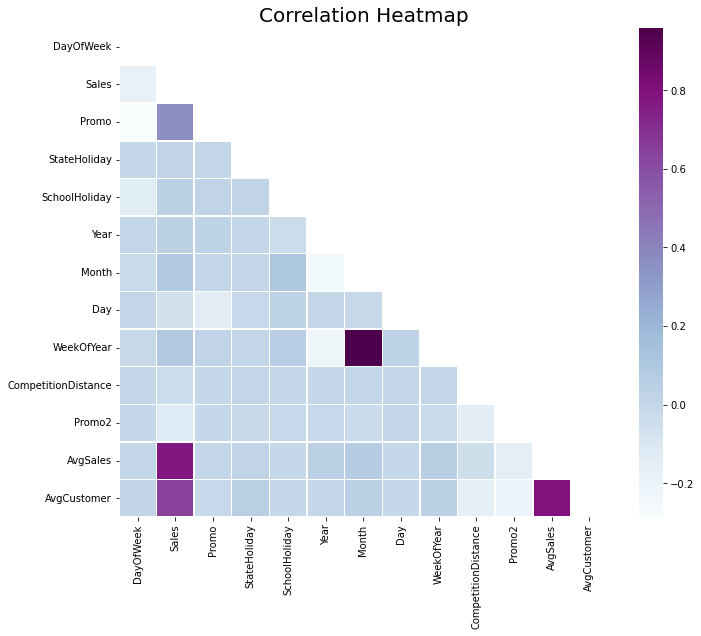

In [77]:
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize = (11, 9))
# sns.heatmap(corr, mask = mask,square = True, linewidths = .5, ax = ax, cmap = "BuPu")
sns.heatmap(corr,square = True,mask=mask, linewidths = .5,ax=ax, cmap = "BuPu")
plt.title("Correlation Heatmap", fontsize=20)

### Interpretation:

We can first see the 0.8 between AvgCustomers and Avgsales which suggests that they are positively correlated like we stated above in the analysis.

It's interesting to see that Sales and Promo ( more than 0.2) actually correlate positively, since running a promotion increases that number .


Sales correlates with Competition Distance(more than 0.1), in a positive manner, like we said up the higher the competitionn distance the more sales per customer we do, which makes sense , the further our competition, the more monopolization Rossman can achieve in the region.

Additionally, the effect of promo to Sales like we said above as well(about 0.4), it did provoke a change in the buying pattern and increased it when continuous promotion were applied.


###<B> Conclusion of Exploratory Analysis:


At this stage, we got a solid understanding of the distributions, the statistical properties and the relationships of our variables. The next step is to identify what variables to model for training and to work on the modeling part of the project

#<b>6. Encode the data

In [78]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [79]:
target = ['Sales']
numeric_col = ['Customers', 'Open', 'Promo', 'Promo2', 'StateHoliday', 'SchoolHoliday', 'CompetitionDistance']
categorical_col = ['DayOfWeek', 'Quarter', 'Month', 'Year', 'StoreType', 'Assortment', 'Season']

In [80]:
def create_encode(df, col):
    le = LabelEncoder()
    a = le.fit_transform(data[col]).reshape(-1,1)
    ohe = OneHotEncoder(sparse=False)
    col_names = [col+ "_" + str(i) for i in le.classes_]
    return (pd.DataFrame(ohe.fit_transform(a), columns = col_names))

#<B>7. Store Sales Prediction

##<b> 7.1 Data Splitting 

In [81]:
df = data.sample(n=50000, random_state=1)

In [82]:
# split features and labels
X = df.drop('Sales', axis=1)
y = df.Sales

In [83]:
# get dummy variables for categorical features for linear regression
X_dummies=X.copy()
X_dummies = pd.get_dummies(X_dummies)

In [84]:
# label nominal variables for tree based regression
X_label = X.copy()

from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
X_label.Assortment = label.fit_transform(X_label.Assortment)
X_label.StoreType = label.fit_transform(X_label.StoreType)
X_label.StateHoliday = label.fit_transform(X_label.StateHoliday)

#Train-Test Split

You now need to split our variable into training and testing sets. You'll perform this by importing train_test_split from the sklearn.model_selection library. It is usually a good practice to keep 70% of the data in your train dataset and the rest 30% in your test dataset

In [85]:
# split training and test datasets
from sklearn.model_selection import train_test_split
Xd_train, Xd_test, yd_train, yd_test = train_test_split(X, y, train_size = 0.7, test_size = 0.3, random_state = 100)
Xd_train,Xd_test,yd_train,yd_test = train_test_split(X_dummies,y,test_size=0.3, random_state=1)
Xl_train,Xl_test,yl_train,yl_test = train_test_split(X_label,y,test_size=0.3, random_state=1)

In [86]:
# Let's now take a look at the train dataset
Xd_train.head()

,DayOfWeek,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,CompetitionDistance,Promo2,AvgSales,AvgCustomer,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
668920,6,0,0,0,2013,8,24,34,1310.0,1,6341.592593,567.444444,1,0,0,0,1,0,0
37690,2,0,0,0,2015,6,23,26,560.0,1,7451.560000,756.000000,1,0,0,0,1,0,0
437004,6,0,0,0,2014,3,29,13,9230.0,1,6749.807692,556.961538,0,0,0,1,0,0,1
690799,4,1,0,1,2013,8,1,31,29910.0,0,4665.518519,539.444444,1,0,0,0,1,0,0
580662,4,1,0,0,2013,11,21,47,19700.0,1,6507.269231,545.807692,0,0,0,1,1,0,0


In [87]:
yd_train.head()

668920    3408
37690     6194
437004    6079
690799    6373
580662    7070
Name: Sales, dtype: int64

##<b> 7.2 Linear Regression

In [88]:
from sklearn.linear_model import LinearRegression
lin= LinearRegression()
linreg = lin.fit(Xd_train, yd_train)

In [89]:
# definte RMSE function
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(x, y):
    return sqrt(mean_squared_error(x, y))

# definte MAPE function
def mape(x, y): 
    return np.mean(np.abs((x - y) / x)) * 100  
  
# get cross validation scores 
yd_predicted = linreg.predict(Xd_train)
yd_test_predicted = linreg.predict(Xd_test)

print("Regresion Model Score" , ":" , linreg.score(Xd_train, yd_train) , "," ,
      "Out of Sample Test Score" ,":" , linreg.score(Xd_test, yd_test))
print("Training RMSE", ":", rmse(yd_train, yd_predicted),
      "Testing RMSE", ":", rmse(yd_test, yd_test_predicted))
print("Training MAPE", ":", mape(yd_train, yd_predicted),
      "Testing MAPE", ":", mape(yd_test, yd_test_predicted))

Regresion Model Score : 0.7534426463092014 , Out of Sample Test Score : 0.7374031695181285
Training RMSE : 1558.666986443433 Testing RMSE : 1569.7998978110754
Training MAPE : 16.994613661283044 Testing MAPE : 17.223983944754266


Need to import the statsmodel.api library using which will help to perform the linear regression.

In [90]:
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



By default, the statsmodels library fits a line on the dataset which passes through the origin. But in order to have an intercept, you need to manually use the add_constant attribute of statsmodels. And once you've added the constant to your Xd_train dataset, you can go ahead and fit a regression line using the OLS (Ordinary Least Squares) attribute of statsmodels as shown below

In [91]:
# Add a constant to get an intercept
Xd_train_sm = sm.add_constant(Xd_train)

# Fit the resgression line using 'OLS'
lr = sm.OLS(yd_train, Xd_train_sm).fit()

In [92]:
# Print the parameters, i.e. the intercept and the slope of the regression line fitted
lr.params

const                 -15602.042781
DayOfWeek               -143.316484
Promo                   2162.113987
StateHoliday            -427.226558
SchoolHoliday            190.833290
Year                      11.950262
Month                    -74.954386
Day                       -3.782284
WeekOfYear                24.282954
CompetitionDistance        0.006542
Promo2                    29.806530
AvgSales                   0.847149
AvgCustomer                1.052652
StoreType_a            -3910.319473
StoreType_b            -3972.876704
StoreType_c            -3928.478568
StoreType_d            -3790.368036
Assortment_a           -4960.196464
Assortment_b           -5776.639295
Assortment_c           -4865.207021
dtype: float64

In [93]:
# Performing a summary operation lists out all the different parameters of the regression line fitted
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     6288.
Date:                Fri, 26 Nov 2021   Prob (F-statistic):               0.00
Time:                        13:10:11   Log-Likelihood:            -3.0697e+05
No. Observations:               35000   AIC:                         6.140e+05
Df Residuals:                   34982   BIC:                         6.141e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                -1.56e+04   1

<B>Looking at some key statistics from the summary

The values we are concerned with are -

1. The coefficients and significance (p-values)
2. R-squared
3. F statistic and its significance

1. The coefficient for Average sales is 0.8472, with a very low p value.

2. R - squared is 0.753
Meaning that 75.3% of the variance in Sales
This is a decent R-squared value.

3. F statistic has a very low p value (practically low)
Meaning that the model fit is statistically significant, and the explained variance isn't purely by chance.

##<b> 7.3 Bayesian Ridge Regression

In [94]:
from sklearn.linear_model import BayesianRidge
rdg = BayesianRidge()
rdgreg = rdg.fit(Xd_train, yd_train)

In [95]:
# validation
print("Regresion Model Score" , ":" , rdgreg.score(Xd_train, yd_train) , "," ,
      "Out of Sample Test Score" ,":" , rdgreg.score(Xd_test, yd_test))

yd_predicted = rdgreg.predict(Xd_train)
yd_test_predicted = rdgreg.predict(Xd_test)

print("Training RMSE", ":", rmse(yd_train, yd_predicted),
      "Testing RMSE", ":", rmse(yd_test, yd_test_predicted))
print("Training MAPE", ":", mape(yd_train, yd_predicted),
      "Testing MAPE", ":", mape(yd_test, yd_test_predicted))

Regresion Model Score : 0.7534416656134255 , Out of Sample Test Score : 0.7373596254116661
Training RMSE : 1558.6700862832608 Testing RMSE : 1569.930045422313
Training MAPE : 16.994522837437668 Testing MAPE : 17.22370067239497


##<b> 7.4 LARS Lasso Regression




In [96]:
from sklearn.linear_model import LassoLars
las = LassoLars(alpha=0.3, fit_intercept=False, normalize=True)
lasreg = las.fit(Xd_train, yd_train)

In [97]:
print("Regresion Model Score" , ":" , lasreg.score(Xd_train, yd_train) , "," ,
      "Out of Sample Test Score" ,":" , lasreg.score(Xd_test, yd_test))

yd_predicted = lasreg.predict(Xd_train)
yd_test_predicted = lasreg.predict(Xd_test)

print("Training RMSE", ":", rmse(yd_train, yd_predicted),
      "Testing RMSE", ":", rmse(yd_test, yd_test_predicted))
print("Training MAPE", ":", mape(yd_train, yd_predicted),
      "Testing MAPE", ":", mape(yd_test, yd_test_predicted))

Regresion Model Score : 0.7534242474036911 , Out of Sample Test Score : 0.737279530870145
Training RMSE : 1558.7251417391271 Testing RMSE : 1570.1694093096548
Training MAPE : 16.995601772979512 Testing MAPE : 17.223041874169997


##<b> 7.5 K-Nearest Neighbor Regression

In [93]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors = 30)
knnreg = knn.fit(Xd_train, yd_train)

In [94]:
print("Regresion Model Score" , ":" , knnreg.score(Xd_train, yd_train) , "," ,
      "Out of Sample Test Score" ,":" , knnreg.score(Xd_test, yd_test))

yd_predicted = knnreg.predict(Xd_train)
yd_test_predicted = knnreg.predict(Xd_test)

print("Training RMSE", ":", rmse(yd_train, yd_predicted),
      "Testing RMSE", ":", rmse(yd_test, yd_test_predicted))
print("Training MAPE", ":", mape(yd_train, yd_predicted),
      "Testing MAPE", ":", mape(yd_test, yd_test_predicted))

Regresion Model Score : 0.6275829231074073 , Out of Sample Test Score : 0.5761647172167876
Training RMSE : 1915.6190634834409 Testing RMSE : 1994.3349960691344
Training MAPE : 22.92328723312777 Testing MAPE : 23.86808737338713


In [ ]:
for x in range(1,30):
    knn = KNeighborsRegressor(n_neighbors = x)
    knnreg = knn.fit(Xd_train, yd_train)
    print("Regresion Model Score" , ":" , knnreg.score(Xd_train, yd_train) , "," ,
      "Out of Sample Test Score" ,":" , knnreg.score(Xd_test, yd_test))

Regresion Model Score : 1.0 , Out of Sample Test Score : 0.2560582567580836
Regresion Model Score : 0.8260280353776119 , Out of Sample Test Score : 0.4244378331607054
Regresion Model Score : 0.7624828146157315 , Out of Sample Test Score : 0.48616905577417047
Regresion Model Score : 0.7295772118189889 , Out of Sample Test Score : 0.5119259413797533
Regresion Model Score : 0.7083945329312091 , Out of Sample Test Score : 0.5316113458878855
Regresion Model Score : 0.6920948075644551 , Out of Sample Test Score : 0.5419683336801244
Regresion Model Score : 0.6818876875076971 , Out of Sample Test Score : 0.5474800002284684
Regresion Model Score : 0.673777214265157 , Out of Sample Test Score : 0.5529030760626559
Regresion Model Score : 0.6679792689422281 , Out of Sample Test Score : 0.5579248830238358
Regresion Model Score : 0.6616025760495636 , Out of Sample Test Score : 0.5618704470151104
Regresion Model Score : 0.6561663024850025 , Out of Sample Test Score : 0.5634889369127833
Regresion Mode

KeyboardInterrupt: ignored

## **7.6 Decison Tree Regression**

In [98]:
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor(min_samples_leaf=20)
treereg = tree.fit(Xd_train, yd_train)

In [99]:
print("Regresion Model Score" , ":" , treereg.score(Xd_train, yd_train) , "," ,
      "Out of Sample Test Score" ,":" , treereg.score(Xd_test, yd_test))

yd_predicted = treereg.predict(Xd_train)
yd_test_predicted = treereg.predict(Xd_test)
print("Training RMSE", ":", rmse(yd_train, yd_predicted),
      "Testing RMSE", ":", rmse(yd_test, yd_test_predicted))
print("Training MAPE", ":", mape(yd_train, yd_predicted),
      "Testing MAPE", ":", mape(yd_test, yd_test_predicted))

Regresion Model Score : 0.854477787801514 , Out of Sample Test Score : 0.7912679860398468
Training RMSE : 1197.4544462444844 Testing RMSE : 1399.5682710880465
Training MAPE : 12.474392715790573 Testing MAPE : 14.703974573710326


## **7.7 Random Forest Regression**

In [100]:
from sklearn.ensemble import RandomForestRegressor
rdf = RandomForestRegressor(n_estimators=30)
rdfreg = rdf.fit(Xd_train, yd_train)

In [101]:
print("Regresion Model Score" , ":" , rdfreg.score(Xd_train, yd_train) , "," ,
      "Out of Sample Test Score" ,":" , rdfreg.score(Xd_test, yd_test))   

yl_predicted = rdfreg.predict(Xd_train)
yl_test_predicted = rdfreg.predict(Xd_test)

print("Training RMSE", ":", rmse(yd_train, yd_predicted),
      "Testing RMSE", ":", rmse(yd_test, yd_test_predicted))
print("Training MAPE", ":", mape(yd_train, yd_predicted),
      "Testing MAPE", ":", mape(yd_test, yd_test_predicted))

Regresion Model Score : 0.9780850241616601 , Out of Sample Test Score : 0.8419515227262482
Training RMSE : 1197.4544462444844 Testing RMSE : 1399.5682710880465
Training MAPE : 12.474392715790573 Testing MAPE : 14.703974573710326


## **Model Selection**

# 1. **Linear Regresion Model Score : 0.7534** 

Training RMSE : 1558.6669             Testing RMSE : 1569.7998

Training MAPE : 16.9946               Testing MAPE : 17.2239

---



# 2. **Ridge Regresion Model Score : 0.7534**

Training RMSE : 1558.6701            Testing RMSE : 1569.9300

Training MAPE : 16.9945              Testing MAPE : 17.2237

---



# 3. **Lasso Regresion Model Score : 0.7534** 

Training RMSE : 1558.7251           Testing RMSE : 1570.1694

Training MAPE : 16.9956             Testing MAPE : 17.2230

---



# 4. **K- Nearest Neighbor Regresion Model Score : 0.6275** 

Training RMSE : 1915.6365           Testing RMSE : 1994.3278

Training MAPE : 22.9235             Testing MAPE : 23.8679

---



# 5. **Decision Tree Regresion Model Score : 0.8544**

Training RMSE : 1197.4544           Testing RMSE : 1399.7321

Training MAPE : 12.4743             Testing MAPE : 14.7060

---



# **6. Random Forest Regresion Model Score : 0.9779**

Training RMSE : 1197.4544           Testing RMSE : 1399.7321

Training MAPE : 12.4743             Testing MAPE : 14.7060

---






# Best Model is Random Forest Regresion Model with highest model score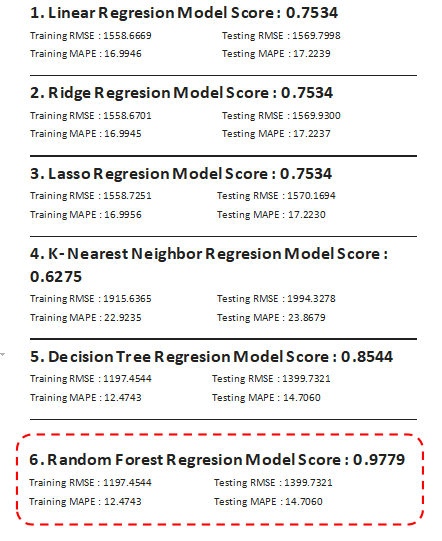

#<B> Feature Importance

In [127]:
from sklearn.ensemble import RandomForestRegressor
rdf = RandomForestRegressor(n_estimators=30)
rdfreg = rdf.fit(Xl_train, yl_train)

Text(0.5, 0, 'Relative Importance')

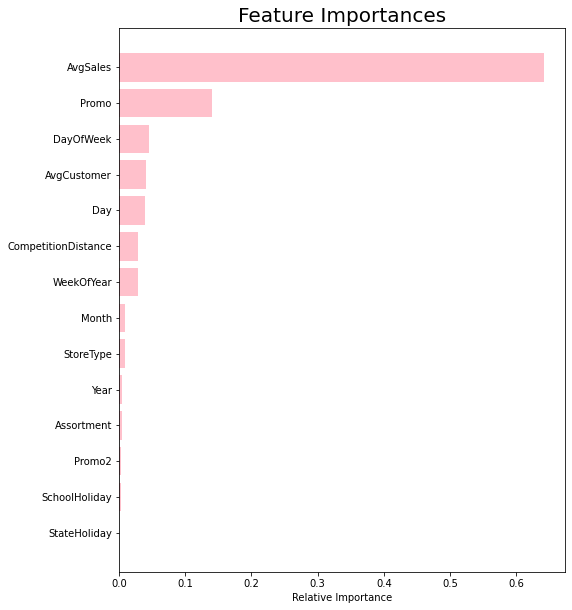

In [128]:
features = Xl_train.columns
importances = rdfreg.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(8,10))
plt.title('Feature Importances', fontsize=20)
plt.barh(range(len(indices)), importances[indices], color='pink', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

# **Facebook Prophet Model for Sales Prediction**

The Facebook Prophet package is designed to analyze time series data with daily observations, which can display patterns on different time scales. Prophet is optimized for business tasks with the following characteristics:

hourly, daily, or weekly observations with at least a few months (preferably a year) of history strong multiple “human-scale” seasonalities: day of week and time of year important holidays that occur at irregular intervals that are known in advance (e.g. the Super Bowl) a reasonable number of missing observations or large outliers historical trend changes, for instance due to product launches or logging changes trends that are non-linear growth curves.

According to the "facebook research" website, there is four main component inside the facebook prophet model.

** A piecewise linear or logistic growth trend.

** A yearly seasonal component modeled using Fourier series.

** A weekly seasonal component using dummy variables.

** A user-provided list of important holidays.

The method of combing different models into one makes the facebook prophet model much more precise and flexible.

In [129]:
train = pd.read_csv("/content/drive/MyDrive/Retail Sales Prediction-Capstone 2/Data & Resources/Rossmann Stores Data.csv", parse_dates = True, low_memory = False)

In [130]:
!pip install fbprophet
import fbprophet
# Visualization tool: leverage plotly for interactive visualization
from fbprophet.plot import plot_plotly, plot_components_plotly   

In [131]:
train['SalesPerCustomer'] = train['Sales']/train['Customers']
train['SalesPerCustomer'].head()

train = train.dropna()

In [132]:
sales = train[train.Store == 1].loc[:, ['Date', 'Sales']]

# reverse to the order: from 2013 to 2015
sales = sales.sort_index(ascending = False)

sales['Date'] = pd.DatetimeIndex(sales['Date'])
sales.dtypes

Date     datetime64[ns]
Sales             int64
dtype: object

In [133]:
sales = sales.rename(columns = {'Date': 'ds',
                                'Sales': 'y'})

In [134]:
sales.head()

,ds,y
1014980,2013-01-02,5530
1013865,2013-01-03,4327
1012750,2013-01-04,4486
1011635,2013-01-05,4997
1009405,2013-01-07,7176


Now, despite of the naive model, we will apply our sales set to the face book model by using the function fbprophet. fbprophet.Prophet can change the value of "changepoint_prior_scale" to 0.05 to achieve a better fit or to 0.15 to control how sensitive the trend is.

In [135]:
sales_prophet = fbprophet.Prophet(changepoint_prior_scale=0.05, daily_seasonality=True)
sales_prophet.fit(sales)

We will figure out the best forecasting by changing the value of changepoints.

If we find that our model is is fitting too closely to our training data (overfitting), our data will not be able to generalize new data.

If our model is not fitting closely enough to our training data (underfitting), our data has too much bias.

Underfitting: increase changepoint to allow more flexibility Overfitting: decrease changepoint to limit flexibili

In [136]:
# Try 4 different changepoints
for changepoint in [0.001, 0.05, 0.1, 0.5]:
    model = fbprophet.Prophet(daily_seasonality=False, changepoint_prior_scale=changepoint)
    model.fit(sales)
    
    future = model.make_future_dataframe(periods=365, freq='D')
    future = model.predict(future)
    
    sales[changepoint] = future['yhat']

We can now create the plot under all of the situation.

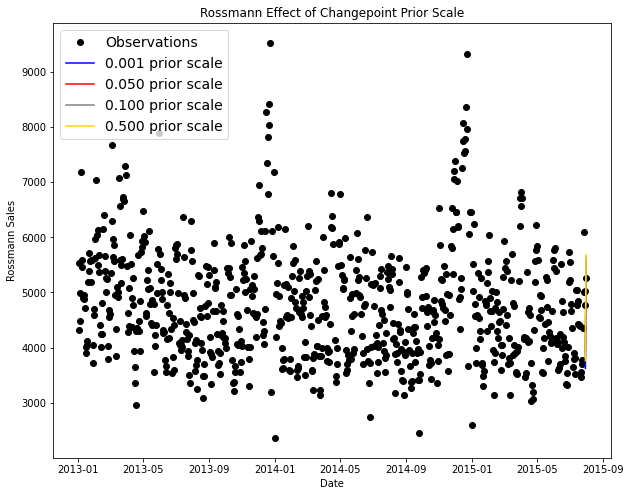

In [137]:
# Create the plot
plt.figure(figsize=(10, 8))

# Actual observations
plt.plot(sales['ds'], sales['y'], 'ko', label = 'Observations')
colors = {0.001: 'b', 0.05: 'r', 0.1: 'grey', 0.5: 'gold'}

# Plot each of the changepoint predictions
for changepoint in [0.001, 0.05, 0.1, 0.5]:
    plt.plot(sales['ds'], sales[changepoint], color = colors[changepoint], label = '%.3f prior scale' % changepoint)
    
plt.legend(prop={'size': 14})
plt.xlabel('Date'); plt.ylabel('Rossmann Sales'); plt.title('Rossmann Effect of Changepoint Prior Scale');

Predictions for 6 Weeks In order to make forecasts, we need to create a future dataframe. We need to specify the amount of future periods to predict and the frequency of our prediction.

Periods: 6 Weeks

Frequency: Daily

In [138]:
# Make a future dataframe for 6weeks
sales_forecast = sales_prophet.make_future_dataframe(periods=6*7, freq='D')
# Make predictions
sales_forecast = sales_prophet.predict(sales_forecast)

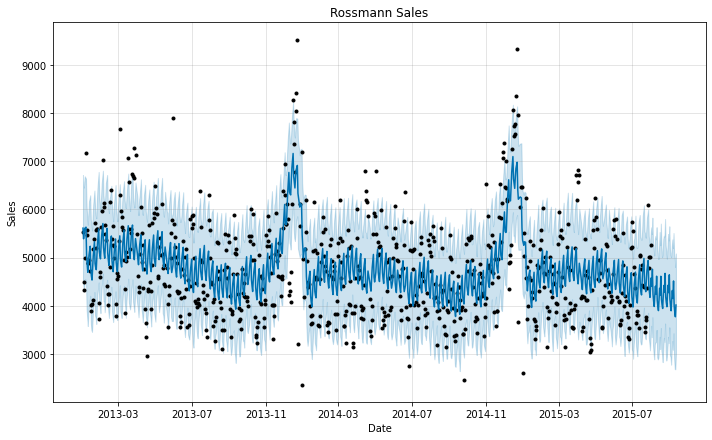

In [139]:
sales_prophet.plot(sales_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Rossmann Sales');

In [140]:
sales_forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
818,2015-09-07,4875.113540,3426.900870,5510.852838,4873.286966,4876.967978,-360.936847,-360.936847,-360.936847,-208.305595,-208.305595,-208.305595,408.262271,408.262271,408.262271,-560.893523,-560.893523,-560.893523,0.0,0.0,0.0,4514.176693
819,2015-09-08,4875.064763,2908.439519,5096.045320,4873.143206,4876.989643,-869.184832,-869.184832,-869.184832,-208.305595,-208.305595,-208.305595,-82.286586,-82.286586,-82.286586,-578.592651,-578.592651,-578.592651,0.0,0.0,0.0,4005.879931
820,2015-09-09,4875.015985,2683.191828,4982.130131,4873.027079,4877.035082,-1002.488585,-1002.488585,-1002.488585,-208.305595,-208.305595,-208.305595,-199.837745,-199.837745,-199.837745,-594.345245,-594.345245,-594.345245,0.0,0.0,0.0,3872.527401
821,2015-09-10,4874.967208,2679.569321,4805.530158,4872.925385,4877.050761,-1104.891189,-1104.891189,-1104.891189,-208.305595,-208.305595,-208.305595,-289.008836,-289.008836,-289.008836,-607.576757,-607.576757,-607.576757,0.0,0.0,0.0,3770.076019
822,2015-09-11,4874.918430,3018.815052,5085.220072,4872.765956,4877.096569,-860.315531,-860.315531,-860.315531,-208.305595,-208.305595,-208.305595,-34.245837,-34.245837,-34.245837,-617.764099,-617.764099,-617.764099,0.0,0.0,0.0,4014.602899


Prophet components plot which graphically describes the model it has fit


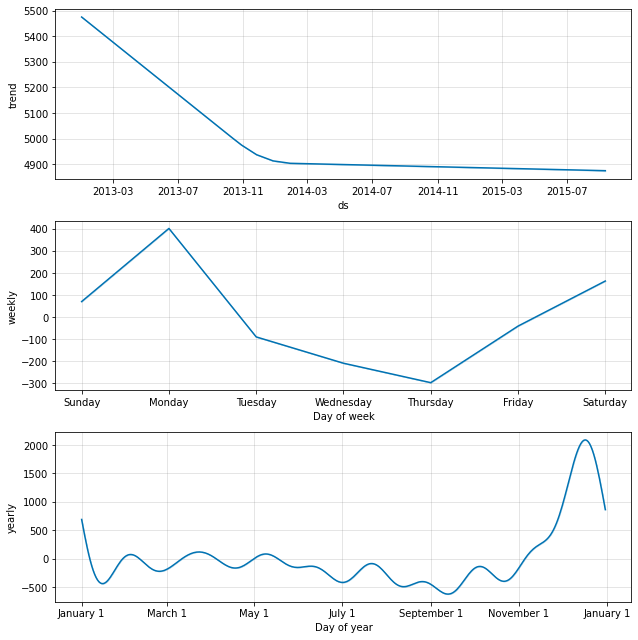

In [141]:
figure2= model.plot_components(sales_forecast)

In [142]:
# Interactive methods
plot_components_plotly(model, sales_forecast)

In [143]:
sales_prophet.changepoints[:10]

25    2013-01-31
50    2013-03-01
75    2013-04-02
100   2013-05-02
125   2013-06-04
150   2013-07-03
174   2013-07-31
199   2013-08-29
224   2013-09-27
249   2013-10-28
Name: ds, dtype: datetime64[ns]

We have listed out the most significant changepoints in our data. This is representing when the time series growth rate significantly changes.

# Converting prediction database to output .csv file 

In [145]:
sales_forecast.to_csv('Retail_sales_Prediction')

##<b>Findings:



Our top 5 most important variables are:



1) Competitor Distance: This indeed impacts a lot the sales of a store like we saw previously in our EDA, when competition is very far stores tend to sell a lot more.

2) Promo: Promotion is primordial for a store to increase its sales, it allows price breaking and thus more customers intersted in buying. Rossmann should focus on increasing the promotional offers per quarter for a,c,d and can minimize for b. Rossmann can divert some of the Promos from being offered on SchoolHolidays to No SchoolHolidays to maximise the Sales revenue. 
Rossman should try to focus on reducing the Promo offers for store type b during StateHolidays as there is no substantial increase in Sales.
·Sales are increased during Christmas week, this might be due to the fact that people buy more beauty products during a Christmas celebration.

3) Store: The Store itself represents a unique identificator for the algorithm to recognise which store has what attributes and indeed better accounts for the forecasting of those same stores in a future timeline. The most selling and crowded store type is B.
Sales is highly correlated to the number of Customers.
For all stores, Promotion leads to increase in Sales and Customers both.
The stores which are opened during the School Holiday have more sales than normal days.
·More stores are opened during School holidays than State holidays.

4) CompetitionOpenSince: The merging of this variable paid out and allowed us to give more accurate predicitions of the sales based on the time of opening of those competitors. Absence of values in features CompetitionOpenSinceYear/Month doesn’t indicate the absence of competition as CompetitionDistance values are not null where the other two values are null.

5) DayofWeek: Like we said, during a week , the pattern varies a lot if it's a sunday or a monday (like we saw in our EDA) for instance and each day in the week has his own attributes and properties that allow to know how much are we going to sell.






#<B>Conclusion


In this notebook, we made different math model for the Rossmann store sales dataset to forecast the future sales. Random forest Regression model brings us a basic understanding of how the math model works, while Facebook prophet model calculates the best solid result. 

